<h2> Redes Neurais e Aprendizado Profundo <h2>

- Convoluções Separáveis em Profundidade (Depthwise Separable Convolution)

## Parte 0 - Bibliotecas e Dataset

In [ ]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [ ]:
#Padronizando sememente aleatória
torch.manual_seed(123)

#Device
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

#Transformando dados para o tensor
transform = transforms.ToTensor()

#Conjunto de treinamento MNIST
train = datasets.MNIST(root = '.', train = True, download = True, transform=transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)

#Conjunto de teste MNIST
test = datasets.MNIST(root = '.', train = False, download = True, transform=transform)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 105496405.05it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 118760484.14it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 13699011.97it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21357095.03it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Parte 1 - Intuição das Convoluções Separáveis em Profundidade

In [ ]:
#Apresentando uma convolução 2d normal
conv = nn.Conv2d(in_channels=10, out_channels=32, kernel_size=3)

#gerando número aleatórios para o input
x = torch.rand(5, 10, 50, 50)

#Armazenando uma saída qualquer
out = conv(x)

#Verificando a quantidade de parâmetros da conv
params = sum(p.numel() for p in conv.parameters() if p.requires_grad)
print(f"A convolução padrão utiliza {params} parâmetros.")

A convolução padrão utiliza 2912 parâmetros.


In [ ]:
#Apresentando a ideia das Convoluções Separáveis em Profundidade (Depthwise Separable Convolution)

#Conv2d 3x3 - primeiro lateral
depthwise_conv = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, groups=10)

#Conv2d 1x1 - depois em profundidade
pointwise_conv = nn.Conv2d(in_channels=10, out_channels=32, kernel_size=1)

#Unindo as camadas
depthwise_separable_conv = torch.nn.Sequential(depthwise_conv, pointwise_conv)

#Armazenando saída
out_depthwise = depthwise_separable_conv(x)

#Verificando a quantidade de parâmetros da Depthwise Separable Convolution
params_depthwise = sum(p.numel() for p in depthwise_separable_conv.parameters() if p.requires_grad)
print(f"As convoluções separáveis utilizam {params_depthwise} parâmetros.")

As convoluções separáveis utilizam 452 parâmetros.


## Parte 1 - Arquitetura simples de uma Depthwise Separable Convolution | Convoluções Separáveis

Exemplo de uma simples convolução separável.


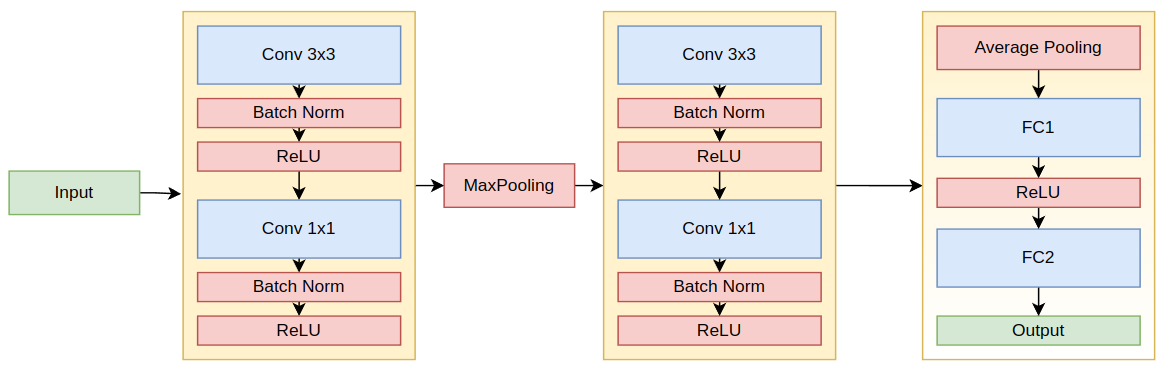

In [ ]:
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, channels):
        super(DepthwiseSeparableConv2d, self).__init__()

        #Conv 3x3
        self.depthwise = nn.Sequential(
                            nn.Conv2d(in_channels=channels[0], out_channels=channels[0], kernel_size=3, padding=1
                                      ),
                            nn.BatchNorm2d(channels[0]),
                            nn.ReLU(inplace=True)
                            )
        #Conv 1x1
        self.pointwise = nn.Sequential(
                            nn.Conv2d(in_channels=channels[0], out_channels=channels[1], kernel_size=1),
                            nn.BatchNorm2d(channels[1]),
                            nn.ReLU(inplace=True)
                         )

    def forward(self, x):

        out = self.pointwise(self.depthwise(x))

        return out

In [ ]:
class CNN_Depthwise_Separable(nn.Module):
    def __init__(self):
        super(CNN_Depthwise_Separable, self).__init__()

        self.sep_conv1 = DepthwiseSeparableConv2d(channels=[1, 32])
        self.sep_conv2 = DepthwiseSeparableConv2d(channels=[32, 64])

        self.avgpool = nn.AvgPool2d(2)
        self.maxpool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(576, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)


    def forward(self, x):

        out = self.maxpool(self.sep_conv1(x))
        out = self.maxpool(self.sep_conv2(out))
        out = self.avgpool(out)

        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)

        return out


In [ ]:
#Número de classes de acordo com o dataset MNIST
num_classes = 10

model_sep_conv = CNN_Depthwise_Separable()
total_params = sum(p.numel() for p in model_sep_conv.parameters())
print(f"Número de parâmetros da rede: {total_params}\n")

#Instanciando a nossa classe de bloco de Indentidade
model_sep_conv = CNN_Depthwise_Separable()

#Função de custo/perda
criterion = nn.CrossEntropyLoss()

#Optimizador
optimizer = optim.Adam(model_sep_conv.parameters())

#Passando a rede para a GPU
print(model_sep_conv.to(device))
print()

#Visualizando os parâmetros
for name, param in model_sep_conv.named_parameters():
  print(name, param.shape)

Número de parâmetros da rede: 70402

CNN_Depthwise_Separable(
  (sep_conv1): DepthwiseSeparableConv2d(
    (depthwise): Sequential(
      (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (pointwise): Sequential(
      (0): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (sep_conv2): DepthwiseSeparableConv2d(
    (depthwise): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (pointwise): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:
#Função para calcular a acurária da rede
def model_accuracy(model, data_loader):

  correct_pred = 0
  num_examples = 0

  for i, (inputs, labels) in enumerate(data_loader):

    inputs, labels = inputs.to(device), labels.to(device)
    logits = model(inputs)
    _, predicted_labels = torch.max(logits, 1)
    num_examples += labels.size(0)
    correct_pred += (predicted_labels == labels).sum()


  return correct_pred.float()/num_examples*100



#Número de épocas para o treinamento da rede
num_epochs = 5

#Função para o calculo de tempo
start_time = time.time()

for epoch in range(num_epochs):

    #Instanciando o modelo para o modo treinamento
    model = model_sep_conv.train()

    for batch_idx, (features, targets) in enumerate(train_loader):

        #Transferindo as imagens e labels para a GPU
        features = features.to(device)
        targets = targets.to(device)

        # FORWARD AND BACK PROP
        logits = model(features) #
        loss = criterion(logits, targets) #Calculo da função de perda
        optimizer.zero_grad()

        loss.backward()

        #Atualizando os parâmetros da rede
        optimizer.step()

        #Log de treinamento
        if not batch_idx % 250:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f'
                   %(epoch+1, num_epochs, batch_idx,
                     len(train_loader), loss))


    #Modo de avalição da rede
    model = model.eval()
    with torch.set_grad_enabled(False):
        print('Época: %03d/%03d acurácia de treinamento: %.2f%%' % (epoch+1, num_epochs,
                                                              model_accuracy(model, train_loader)))
    #Tempo de treinamento de cada epoch
    print('Tempo de treino da epoch %03d: %.2f min\n' % (epoch+1, (time.time() - start_time)/60))

#Tempo total
print('\nTempo de treino total:: %.2f min' % ((time.time() - start_time)/60))

#Avaliação com o conjunto de teste
print('\nAcurácia do modelo no conjunto de teste: %.2f%%' % (model_accuracy(model, test_loader)))

Epoch: 001/005 | Batch 000/469 | Cost: 2.3555
Epoch: 001/005 | Batch 250/469 | Cost: 0.1029
Epoch: 001/005 training accuracy: 96.44%
Time elapsed: 0.31 min
Epoch: 002/005 | Batch 000/469 | Cost: 0.0677
Epoch: 002/005 | Batch 250/469 | Cost: 0.1208
Epoch: 002/005 training accuracy: 96.97%
Time elapsed: 0.56 min
Epoch: 003/005 | Batch 000/469 | Cost: 0.0451
Epoch: 003/005 | Batch 250/469 | Cost: 0.0924
Epoch: 003/005 training accuracy: 97.76%
Time elapsed: 0.80 min
Epoch: 004/005 | Batch 000/469 | Cost: 0.0283
Epoch: 004/005 | Batch 250/469 | Cost: 0.1093
Epoch: 004/005 training accuracy: 98.22%
Time elapsed: 1.04 min
Epoch: 005/005 | Batch 000/469 | Cost: 0.0210
Epoch: 005/005 | Batch 250/469 | Cost: 0.1237
Epoch: 005/005 training accuracy: 98.70%
Time elapsed: 1.30 min

Total Training Time: 1.30 min

Acurácia no conjunto de teste: 98.42%


## Parte 2 -  Comparando com uma CNN tradicional

In [ ]:
class CNNbased(nn.Module):
    def __init__(self, num_classes):
        super(CNNbased, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpooling = nn.MaxPool2d(kernel_size=(2,2))

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(1600, 100)
        self.fc2 = nn.Linear(100, 10)



    def forward(self, x):

        x = self.maxpooling(self.bn1(self.relu(self.conv1(x))))
        x = self.maxpooling(self.bn2(self.relu(self.conv2(x))))

        x = x.view(x.size(0), -1)
        x = self.flatten(x)

        x = self.relu(self.fc1(x))
        #x = self.relu(self.fc2(x))
        x = self.fc2(x)

        return x


In [ ]:
#Alguns parâmetros

#Número de classes de acordo com o dataset MNIST
num_classes = 10

#Taxa de aprendizagem
learning_rate = 0.001

#Instanciando a nossa classe de bloco de Indentidade
plain_cnn = CNNbased(num_classes=num_classes)

#Função de custo/perda
criterion = nn.CrossEntropyLoss()

#Optimizador
optimizer = optim.Adam(plain_cnn.parameters(), lr = learning_rate)

total_params = sum(p.numel() for p in plain_cnn.parameters())
print(f"Número de parâmetros da rede: {total_params}\n")

#Passando a rede para a GPU
print(plain_cnn.to(device))
print()


#Visualizando os parâmetros
for name, param in plain_cnn.named_parameters():
  print(name, param.shape)

Número de parâmetros da rede: 180118

CNNbased(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1600, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

conv1.weight torch.Size([32, 1, 3, 3])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 3, 3])
conv2.bias torch.Size([64])
bn1.weight torch.Size([32])
bn1.bias torch.Size([32])
bn2.weight torch.Size([64])
bn2.bias torch.Size([64])
fc1.weight torch.Size([100, 1600])
fc1.bias torch.Size([100])
fc2.weight torch.Size([10, 100])
fc2.bias torch.Size([10]

In [ ]:
#Função para calcular a acurária da rede
def model_accuracy(model, data_loader):

  correct_pred = 0
  num_examples = 0

  for i, (inputs, labels) in enumerate(data_loader):

    inputs, labels = inputs.to(device), labels.to(device)
    logits = model(inputs)
    _, predicted_labels = torch.max(logits, 1)
    num_examples += labels.size(0)
    correct_pred += (predicted_labels == labels).sum()


  return correct_pred.float()/num_examples*100



#Número de épocas para o treinamento da rede
num_epochs = 5

#Função para o calculo de tempo
start_time = time.time()

for epoch in range(num_epochs):

    #Instanciando o modelo para o modo treinamento
    model = plain_cnn.train()

    for batch_idx, (features, targets) in enumerate(train_loader):

        #Transferindo as imagens e labels para a GPU
        features = features.to(device)
        targets = targets.to(device)

        # FORWARD AND BACK PROP
        logits = model(features) #
        loss = criterion(logits, targets) #Calculo da função de perda
        optimizer.zero_grad()

        loss.backward()

        #Atualizando os parâmetros da rede
        optimizer.step()

        #Log de treinamento
        if not batch_idx % 250:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f'
                   %(epoch+1, num_epochs, batch_idx,
                     len(train_loader), loss))


    #Modo de avalição da rede
    model = model.eval()
    with torch.set_grad_enabled(False):
        print('Época: %03d/%03d acurácia de treinamento: %.2f%%' % (epoch+1, num_epochs,
                                                              model_accuracy(model, train_loader)))
    #Tempo de treinamento de cada epoch
    print('Tempo de treino da epoch %03d: %.2f min\n' % (epoch+1, (time.time() - start_time)/60))

#Tempo total
print('\nTempo de treino total:: %.2f min' % ((time.time() - start_time)/60))

#Avaliação com o conjunto de teste
print('\nAcurácia do modelo no conjunto de teste: %.2f%%' % (model_accuracy(model, test_loader)))

Epoch: 001/005 | Batch 000/469 | Loss: 2.3780
Epoch: 001/005 | Batch 250/469 | Loss: 0.0939
Época: 001/005 acurácia de treinamento: 99.10%
Tempo de treino da epoch 001: 0.24 min

Epoch: 002/005 | Batch 000/469 | Loss: 0.0176
Epoch: 002/005 | Batch 250/469 | Loss: 0.0192
Época: 002/005 acurácia de treinamento: 99.30%
Tempo de treino da epoch 002: 0.47 min

Epoch: 003/005 | Batch 000/469 | Loss: 0.0226
Epoch: 003/005 | Batch 250/469 | Loss: 0.0502
Época: 003/005 acurácia de treinamento: 99.60%
Tempo de treino da epoch 003: 0.70 min

Epoch: 004/005 | Batch 000/469 | Loss: 0.0081
Epoch: 004/005 | Batch 250/469 | Loss: 0.0008
Época: 004/005 acurácia de treinamento: 99.72%
Tempo de treino da epoch 004: 0.94 min

Epoch: 005/005 | Batch 000/469 | Loss: 0.0146
Epoch: 005/005 | Batch 250/469 | Loss: 0.0011
Época: 005/005 acurácia de treinamento: 99.65%
Tempo de treino da epoch 005: 1.17 min


Tempo de treino total:: 1.17 min

Acurácia do modelo no conjunto de teste: 98.95%


## Referências

- **MobileNets: Efficient Convolutional Neural Networks for Mobile Vision
Applications**: https://arxiv.org/pdf/1704.04861.pdf

- **A Basic Introduction to Separable Convolutions:**  https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728

- **Groups, Depthwise, and Depthwise-Separable Convolution (Neural Networks)**: https://www.youtube.com/watch?v=vVaRhZXovbw

- **Parameters almost same in Depthwise Separable Convolution (when compared to a standard CNN)?**: https://discuss.pytorch.org/t/parameters-almost-same-in-depthwise-separable-convolution-when-compared-to-a-standard-cnn/65649